## What is in the notebook:

This notebook gathers together state maternal mortality data, health-insurance data, and income data for states between 2010-2019. It also gathers together various natility data from 2010-2019.

In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy

### Loading Data

#### CDC Maternal mortality data

In [15]:
maternal_mortality_df = pd.read_csv("..\\data\\cdc_data\\all_states_all_codes_by_year.csv")
maternal_mortality_df = maternal_mortality_df[["State", "Year", "Deaths", "Population"]]
print(maternal_mortality_df[maternal_mortality_df.Year>=1995])

              State  Year  Deaths  Population
0           Alabama  1999      10     1801848
1           Alabama  2005      12     1856905
2           Alabama  2006      10     1880993
3           Alabama  2015      12     1929191
4           Alabama  2016      35     1920571
...             ...   ...     ...         ...
1197        Vermont  1995       0      300279
1198        Vermont  1996       0      303034
1199        Vermont  1997       0      304893
1220     Washington  1995       0     2757505
1231  West Virginia  1995       0      941762

[631 rows x 4 columns]


#### ACS Income Data

This data frame needs to be pivoted.

In [102]:
income_df = pd.read_csv("..\\data\\acs_income_by_year\\all_income_from_2010_to_2023.csv")
income_df = income_df[income_df.columns[1:]]
income_df_pivot = pd.pivot(data = income_df,  index ='Year', columns= 'label')
income_df = income_df_pivot.stack(level=0)
income_df.reset_index(inplace=True)
income_df.rename(columns = {"level_1" : "State"},inplace= True)
income_df.head()


C:\Users\david\AppData\Local\Temp\ipykernel_8976\895348341.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  income_df = income_df_pivot.stack(level=0)


label,Year,State,"$10,000 to $14,999","$100,000 to $149,999","$15,000 to $24,999","$150,000 to $199,999","$200,000 or more","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","Less than $10,000",Total
0,2010,Alabama,291136,462295,568262,155190,110550,515050,683128,805464,487371,418610,4499250
1,2010,Alaska,24791,122561,46620,45879,36225,52474,73631,121399,89373,23792,637189
2,2010,Arizona,301174,694479,620656,213517,196895,663570,884336,1119302,695469,414482,5802329
3,2010,Arkansas,186755,243784,379359,68553,56348,371449,442926,508686,289906,236611,2784750
4,2010,California,1486323,4692266,2969203,2048096,2047855,2756878,3942244,5360641,3913537,1690857,30895516


Here we aggregate the income data. Change the boolean ```Agg_Income``` to ```False``` if you do not want to aggregate income.

In [104]:
Agg_Income = False
if Agg_Income:
    income_df['sub_75k_income'] = income_df["Less than $10,000"]+income_df["$10,000 to $14,999"]+income_df["$15,000 to $24,999"]+income_df["$25,000 to $34,999"]+income_df["$35,000 to $49,999"]+income_df["$50,000 to $74,999"]
    income_df['between_75k_150k_income'] = income_df['$75,000 to $99,999']+income_df["$100,000 to $149,999"]
    income_df['above_150k_income'] = income_df['$150,000 to $199,999']+income_df['$200,000 or more']
    income_df = income_df[["State","Year","sub_75k_income",  'between_75k_150k_income',"above_150k_income","Total"]]


#### Natality Data

In [105]:
natility_df = pd.read_csv("StateNatalityDF.csv")
natility_df.head()

,State,Year,Births,ChronicHypertensionBirths,DiabetesBirths,EnclampsiaBirths,Pregnancy-AssociatedHypertensionBirths,TobaccoUseBirths,HospitalBirths,BirthCenterBirths,...,NotReportedInitialCare,Under20Weeks,20-27Weeks,28-31Weeks,32-35Weeks,36Weeks,37-39Weeks,40Weeks,41Weeks,42PlusWeeks
0,Arizona,2010,87477,769.0,3694.0,769.0,3441.0,0.0,86346.0,437,...,87477.0,42.0,465,667.0,3579,3697.0,55528,18468,4671.0,337
1,Arizona,2011,85543,711.0,4014.0,772.0,3599.0,0.0,84380.0,454,...,85543.0,41.0,546,618.0,3421,3354.0,54646,18076,4482.0,321
2,Arizona,2012,86441,807.0,4452.0,634.0,3903.0,0.0,85177.0,505,...,86441.0,54.0,480,688.0,3476,3290.0,55425,18265,4441.0,271
3,Arizona,2013,85600,956.0,4919.0,604.0,4791.0,0.0,84450.0,459,...,85600.0,49.0,437,641.0,3430,3218.0,54667,18067,4787.0,261
4,Arizona,2014,86887,1039.0,6126.0,341.0,4567.0,4675.0,85628.0,511,...,0.0,35.0,474,664.0,3440,3206.0,55382,17920,5388.0,290


#### Behavioral Data
The data points here are included as percents and we have the total female population. We'll scale the data to get absolute values as well.

In [106]:
with open('..\\data\\behavioral_data\\data\\all_states_behavior_data.pkl', 'rb') as file:
    behavior_df = pickle.load(file)
behavior_df.head()
behavior_df = behavior_df[["Year", "State", "Female_Population"	,"Percent_Overweight"	,"Percent_Obese",	"Percent_Overweight_or_Obese"	,"Percent_No_Activity"]]
behavior_df.head()
for c in behavior_df.columns:
    if "Percent" in c:
        s = c.replace("Percent","Absolute")
        behavior_df[s] = behavior_df[c]/100*behavior_df.Female_Population
behavior_df.head()

,Year,State,Female_Population,Percent_Overweight,Percent_Obese,Percent_Overweight_or_Obese,Percent_No_Activity,Absolute_Overweight,Absolute_Obese,Absolute_Overweight_or_Obese,Absolute_No_Activity
0,2011,Alaska,349802,31.3,26.7,58.0,24.0,109488.026,93397.134,202885.16,83952.48
1,2012,Alaska,350355,32.8,25.4,58.2,20.1,114916.44,88990.17,203906.61,70421.355
2,2013,Alaska,350355,31.2,27.5,58.7,21.7,109310.76,96347.625,205658.385,76027.035
3,2014,Alaska,351150,29.4,30.2,59.6,20.3,103238.1,106047.3,209285.4,71283.45
4,2015,Alaska,349737,30.9,30.5,61.4,23.2,108068.733,106669.785,214738.518,81138.984


#### Merging Data Sets (No Scaling)

Here we merge the data sets. Since this is dealing with absolute numbers, I'ved dropped the "Percent" columns in the ```behavior_df``` dataframe.
The natality data is currently commented out. To include that uncomment.


In [134]:
merged_df = pd.merge(left = maternal_mortality_df, right = income_df, on = ["Year","State"], how = 'inner')
print(f"Maternal mortality and income data frame has size {merged_df.shape}.")
merged_df = pd.merge(left = merged_df, right = behavior_df[[c for c in behavior_df.columns if not "Percent" in c]], on =["Year", "State"], how = 'inner' )
print(f'Maternal mortality, income, and behavioral data frame has size {merged_df.shape}')
#merged_df = pd.merge(left = merged_df, right = natility_df, on = ["Year", "State"], how = 'inner')
#print(f"Maternal mortality, income, behavioral, and natality data frame has size {merged_df.shape}.")
merged_df.head()


Maternal mortality and income data frame has size (293, 15).
Maternal mortality, income, and behavioral data frame has size (268, 20)


,State,Year,Deaths,Population,"$10,000 to $14,999","$100,000 to $149,999","$15,000 to $24,999","$150,000 to $199,999","$200,000 or more","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","Less than $10,000",Total,Female_Population,Absolute_Overweight,Absolute_Obese,Absolute_Overweight_or_Obese,Absolute_No_Activity
0,Alabama,2015,12,1929191,271680,539246,523171,189844,165208,489371,619042,849122,536171,375026,4556454,2506169,711751.996,912245.516,1623997.512,844578.953
1,Alabama,2016,35,1920571,255845,564794,507039,207300,175458,478770,611298,822873,570368,375602,4569366,2507248,739638.16,882551.296,1622189.456,824884.592
2,Alabama,2017,41,1916967,256573,621022,496382,202843,190279,450393,605426,826198,555555,336470,4540304,2514851,759485.002,940554.274,1700039.276,900316.658
3,Alabama,2018,31,1913546,236976,623409,490034,233112,210793,437322,586496,815813,596792,358831,4589595,2518600,745505.6,952030.8,1697536.4,851286.8
4,Alabama,2019,35,1910340,222263,697393,460692,266789,233594,454039,610072,849273,564809,326937,4687202,2533574,762605.774,917153.788,1679759.562,869015.882


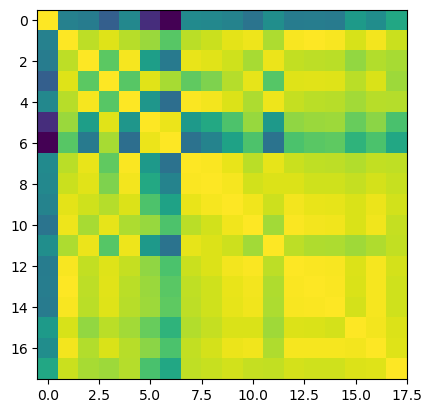

In [135]:
MergeDF_Corr = merged_df[merged_df.columns[2:]].corr(method = 'pearson')
plt.imshow(MergeDF_Corr)

In [136]:
MergeDF_Corr.sort_values("Deaths",ascending= False, inplace = True)
print(MergeDF_Corr.Deaths.head(20))

Deaths                          1.000000
Absolute_No_Activity            0.848163
Absolute_Obese                  0.826916
Less than $10,000               0.806958
Absolute_Overweight_or_Obese    0.805824
$25,000 to $34,999              0.800907
$15,000 to $24,999              0.796654
$35,000 to $49,999              0.796396
$50,000 to $74,999              0.788766
Population                      0.786068
Female_Population               0.780602
Total                           0.778993
$10,000 to $14,999              0.778489
Absolute_Overweight             0.776854
$75,000 to $99,999              0.765907
$100,000 to $149,999            0.733880
$150,000 to $199,999            0.668248
$200,000 or more                0.618992
Name: Deaths, dtype: float64


#### Merged Data for Scaled Data
```merged_df[Death_Rate]``` will be $\displaystyle \frac{\# \textup{Maternal Deaths}}{\textup{Female Population}} \times 1,000,000.$


The income categories are scaled by the ```Total``` index which is the total population of the state.

This doesn't inlcude any ```natality_df``` dataframe information, but that can be incorporated easily. I  just don't know that data as well.

In [137]:
scale_income = copy.copy(income_df)
for c in scale_income.columns:
    if not c in ["State","Year","Total"]:
        scale_income[c] = scale_income[c]/scale_income.Total
scale_income = scale_income[scale_income.columns[:-1]]

merged_df = pd.merge(left = maternal_mortality_df, right = scale_income, on = ["Year","State"], how = 'inner')
print(f"Maternal mortality and income data frame has size {merged_df.shape}.")
merged_df = pd.merge(left = merged_df, right = behavior_df[[c for c in behavior_df.columns if not "Absolute" in c]], on =["Year", "State"], how = 'inner' )
print(f'Maternal mortality, income, and behavioral data frame has size {merged_df.shape}')
merged_df["Death_Rate"] = merged_df.Deaths/merged_df.Female_Population*(10**6)

### Change Column Order
all_column_list = list(merged_df.columns)
all_column_list.remove("Female_Population")
all_column_list.remove("Deaths")
all_column_list.remove("Population")
column_list = ["State","Year", "Death_Rate"]
for c in column_list:
    all_column_list.remove(c)
column_list.extend(all_column_list)

merged_df = merged_df[column_list]



Maternal mortality and income data frame has size (293, 14).
Maternal mortality, income, and behavioral data frame has size (268, 19)


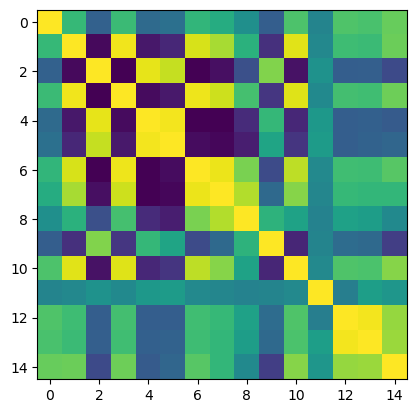

In [138]:
MergeDF_Corr = merged_df[merged_df.columns[2:]].corr(method = 'pearson')
plt.imshow(MergeDF_Corr)


In [139]:
MergeDF_Corr.sort_values("Death_Rate",ascending= False, inplace = True)
print(MergeDF_Corr.Death_Rate.head(20))

Death_Rate                     1.000000
Percent_No_Activity            0.542315
Percent_Obese                  0.459676
Less than $10,000              0.445952
Percent_Overweight_or_Obese    0.438087
$15,000 to $24,999             0.375355
$10,000 to $14,999             0.351074
$25,000 to $34,999             0.329854
$35,000 to $49,999             0.250140
$50,000 to $74,999             0.014052
Percent_Overweight            -0.079669
$200,000 or more              -0.241069
$150,000 to $199,999          -0.288004
$100,000 to $149,999          -0.355637
$75,000 to $99,999            -0.383601
Name: Death_Rate, dtype: float64
